# Overlap

In [1]:
%run -i header.py
import sympy as sym

In [33]:
def overlap(instate, outstate, prefix, p):
    params = json.load(open("quarkEigen/output/{0}.{1}-{0}/config".format(prefix, p), "r"))
    
    pin = params[instate]
    pout = params[outstate]
    
    fin = pd.read_csv("quarkU/output/{0}.{1}-{0}/data/{2}".format(prefix, p, instate))
    fout = pd.read_csv("quarkU/output/{0}.{1}-{0}/data/{2}".format(prefix, p, outstate))
    
    masses = pd.read_csv("data/{}-spectrum.csv".format(p), index_col=0, comment="#")
    masses = masses["LP"] if prefix == "lin" else masses["SP"]

    mi = masses[instate]/10**3
    mf = masses[outstate]/10**3
    
    normIn = sp.sqrt(sp.integrate.trapz(fin["u"]**2, fin["r"]))
    normOut = sp.sqrt(sp.integrate.trapz(fout["u"]**2, fout["r"]))
    
    finterp = sp.interpolate.interp1d(fin["r"], fin["u"]/normIn)
    fouterp = sp.interpolate.interp1d(fout["r"], fout["u"]/normOut)
    
    line = fin["r"] if fin["r"].iloc[-1] < fout["r"].iloc[-1] else fout["r"]
    
    k = -mf + sp.sqrt(mf**2 + 2*mf*(mi - mf))
    #k = (mi**2-mf**2)/2/mi
    
    e1 = {
              "art": 3/k*sp.integrate.trapz(finterp(line)*fouterp(line)*(k*line/2*sp.special.spherical_jn(0, k*line/2) - sp.special.spherical_jn(1, k*line/2)), line)
            , "my": sp.integrate.trapz(finterp(line)*fouterp(line)*line*(sp.special.spherical_jn(0, k*line/2) + sp.special.spherical_jn(2, k*line/2)), line)
            , "my_thesis": (mi-mf)/3*sp.integrate.quad(lambda line: finterp(line)*fouterp(line)*line*(sp.special.spherical_jn(0, k*line/2)+sp.special.spherical_jn(2, k*line/2)), line.iloc[0], line.iloc[-1])[0]
        }
    m1 = {
                "art": 4*sp.pi*sp.integrate.trapz(finterp(line)*fouterp(line)*sp.special.spherical_jn(0, k*line/2), line)
              , "my": sp.sqrt(pin["eq"]["xL"])*sp.integrate.trapz(finterp(line)*fouterp(line)*sp.special.spherical_jn(1, k*line/2), line)
    }
    
    return m1["art"]
    
overlap("chi_c2_2P", "psi_2S", "lin", "c")

6.785348432179347

In [34]:
def width(instate, outstate, prefix, p):
    params = json.load(open("quarkEigen/output/{0}.{1}-{0}/config".format(prefix, p), "r"))
    
    pin = params[instate]
    pout = params[outstate]
    
    if pin["eq"]["xS"] != pout["eq"]["xS"]:
        return 0
    
    masses = pd.read_csv("data/{}-spectrum.csv".format(p), index_col=0, comment="#")
    #masses = masses["LP"] if prefix == "lin" else masses["SP"]
    masses = masses["PDG"]

    mi = masses[instate]/10**3
    mf = masses[outstate]/10**3
    
    pinter = json.load(open("trans/output/{0}.{1}-{0}/config".format(prefix, p), "r"))
    
    k = -mf + sp.sqrt(mf**2 + 2*mf*(mi - mf))
    #k = (mi**2-mf**2)/2/mi
    
    recoil = 1 - k/mi
    
    #return 4*pinter["alphaEM"]*k*(1-k/mi)*overlap(instate, outstate, prefix, p)**2
    #return pinter["alphaEM"]/2*(mi**4-mf**4)/mi**3*overlap(instate, outstate, prefix, p)**2
    
    e1 =   4/3*pinter["alphaEM"]*pout["eq"]["xJ"]\
              *(max(pin["eq"]["xL"], pout["eq"]["xL"])-1)/2\
              *sym.N(cg.wigner_6j(\
                              (pin["eq"]["xJ"]-1)/2, 1, (pout["eq"]["xJ"]-1)/2\
                            , (pout["eq"]["xL"]-1)/2, (pin["eq"]["xS"]-1)/2, (pin["eq"]["xL"]-1)/2\
                           ))**2\
              *k*(mi-mf)**2\
              *overlap(instate, outstate, prefix, p)**2*recoil
    m1 = 4/3*pinter["alphaEM"]/pin["eq"]["env"]["mC"]**2*pout["eq"]["xJ"]/pin["eq"]["xL"]\
              *k**5\
              *overlap(instate, outstate, prefix, p)**2*recoil
    
    return m1

In [35]:
width("chi_c2_2P", "psi_2S", "lin", "c")*10**6

59.35867516067026

In [175]:
cg.wigner_6j(0, 1, 1, 0, 1, 1)

1/3

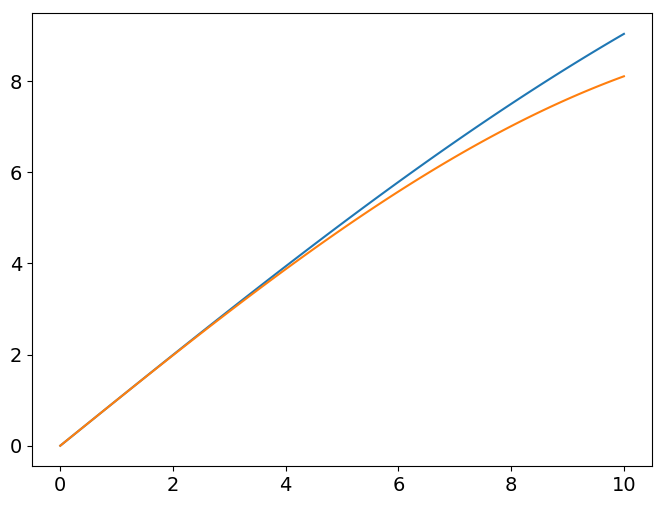

In [194]:
r = sp.linspace(0, 10, 100)
k = 0.2
plt.plot(r, r*(sp.special.spherical_jn(0, k*r/2)+sp.special.spherical_jn(2, k*r/2)))
plt.plot(r, 3/k*(k*r/2*sp.special.spherical_jn(0, k*r/2)-sp.special.spherical_jn(1, k*r/2)))